In [47]:
%pip install -Uqq fastai duckduckgo_search

Note: you may need to restart the kernel to use updated packages.


In [48]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *
from pathlib import Path

ddgs = DDGS()

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddgs.images(keywords=term, max_results=max_images)).itemgot('image')


    Example searching photos using duckduckgo

In [49]:
urls = search_images('grizzly bear photo')
urls

Searching for 'grizzly bear photo'


(#30) ['https://www.publicdomainpictures.net/pictures/240000/velka/grizzly-bear-portrait-1511961987XRY.jpg','https://d3d0lqu00lnqvz.cloudfront.net/media/media/897b2e5d-6d4c-40fa-bbe8-6829455747e2.jpg','https://wallsdesk.com/wp-content/uploads/2017/01/Grizzly-Bear-full-HD.jpg','http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly+Bear+Wildlife.jpg','https://wallpaperset.com/w/full/a/8/1/52280.jpg','https://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg','https://wallpapercave.com/wp/wp4087079.jpg','https://www.goodfreephotos.com/albums/animals/mammals/grizzly-bear-in-the-wild.jpg','https://images.pexels.com/photos/162340/bear-bavarian-bear-wild-brown-bear-162340.jpeg?cs=srgb&dl=animal-bear-cute-162340.jpg&fm=jpg','https://wallpaperfx.com/view_image/amazing-grizzly-bear-1920x1200-wallpaper-7096.jpg'...]

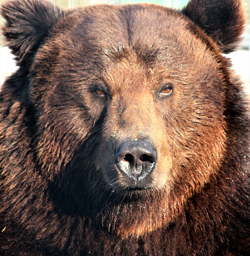

In [50]:
from fastdownload import download_url
dest = 'grizzly.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

In [51]:
bear_types = 'grizzly', 'black', 'teddy' , 'panda' , 'polar' , 'red panda'
bear_types

('grizzly', 'black', 'teddy', 'panda', 'polar', 'red panda')

In [52]:
path = Path('bears_data')

In [53]:
from time import sleep

if not path.exists():
  path.mkdir()
  for bear in bear_types:
    dest = (path/bear)
    dest.mkdir(exist_ok=True)
    download_images(dest, urls=search_images(f'{bear} bear'))
    sleep(10)
    download_images(dest, urls=search_images(f'{bear} bear photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{bear} bear forest'))
    sleep(10)


In [54]:
fns = get_image_files(path)
fns

(#493) [Path('bears_data/grizzly/bd3a9ca2-c4bd-45e7-9dde-c4c7a62e76a3.jpg'),Path('bears_data/grizzly/e0876460-9e7d-44b1-92c6-96baa80cf1f7.jpg'),Path('bears_data/grizzly/a544dfc2-4927-4c27-9552-624b8d022377.jpg'),Path('bears_data/grizzly/60fb5182-b40b-494d-bdef-5fbaa8ae74de.jpg'),Path('bears_data/grizzly/738250af-0165-451c-b803-3439f0bbba8e.jpg'),Path('bears_data/grizzly/edcd7f25-4d0c-4d55-ab90-334c2d002665.jpg'),Path('bears_data/grizzly/19c894aa-f291-42ea-aedd-f67f499e42b5.jpg'),Path('bears_data/grizzly/57c2b492-53fc-4182-a379-35dfeaa45a58.jpg'),Path('bears_data/grizzly/1a420f48-da90-4e41-ae39-61116d23227c.jpg'),Path('bears_data/grizzly/db40dad3-def4-4d4c-aa82-0d99a6e66c5b.jpg')...]

In [55]:
failed = verify_images(fns)
len(failed)

0

In [56]:
## removing failed
failed.map(Path.unlink)

(#0) []

In [57]:
bears_dataset = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(250, min_scale = 0.5),
    batch_tfms=aug_transforms(size=224)
)

In [58]:
dls = bears_dataset.dataloaders(path)

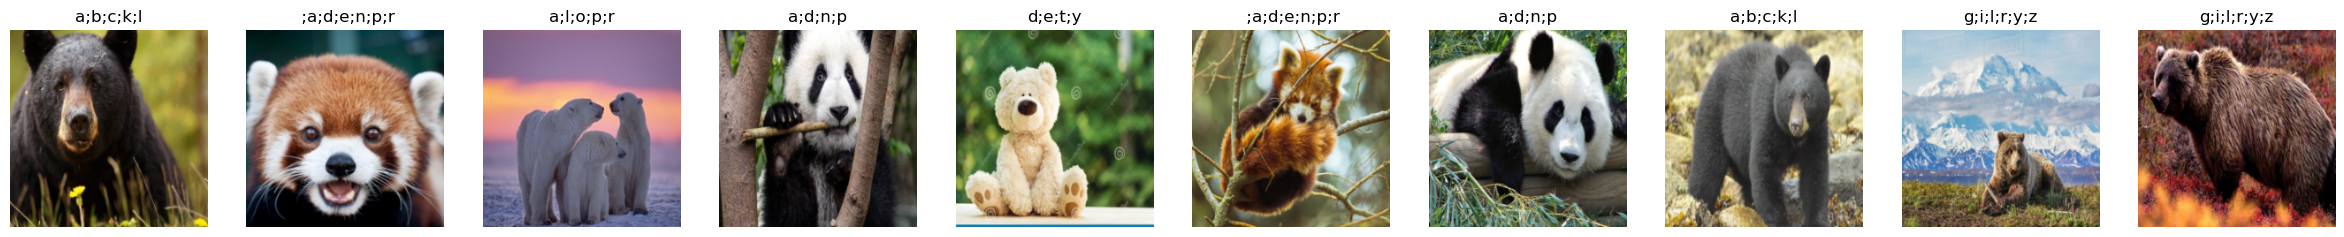

In [59]:
dls.valid.show_batch(max_n=10, nrows=1)

In [60]:
learn = vision_learner(dls, resnet18)

In [61]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [62]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 17])

SuggestedLRs(valley=0.0006918309954926372)

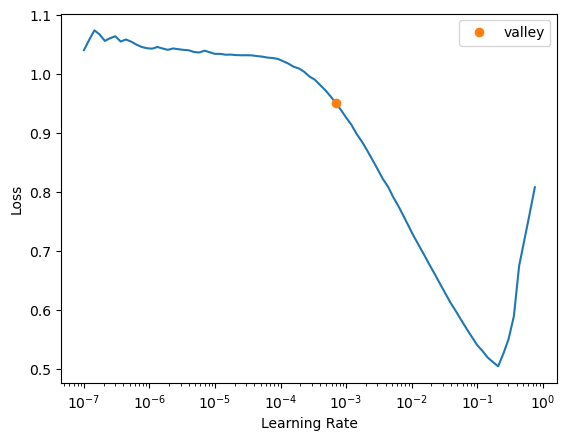

In [63]:
learn = vision_learner(dls, resnet18, metrics = partial(accuracy_multi,thresh=0.6))
learn.lr_find()

In [64]:
learn.fine_tune(5, base_lr=1e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.860490,0.466917,0.808523,00:22
1,0.610951,0.214833,0.935774,00:22
2,0.461625,0.104035,0.969988,00:23
3,0.354857,0.063852,0.983193,00:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.070277,0.137473,0.965786,00:28
1,0.066126,0.054856,0.985594,00:28
2,0.053113,0.025661,0.992797,00:28
3,0.044555,0.024267,0.992197,00:27
4,0.037373,0.018774,0.994598,00:28


In [65]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

learn = vision_learner(dls, resnet, metrics = partial(accuracy_multi,thresh=0.6))
learn.lr_find(suggest_funcs=(minimum, steep))

NameError: name 'resnet' is not defined

In [ ]:
learn.predict(PILImage.create('red-panda.jpeg'))

((#7) [' ','a','d','e','n','p','r'],
 tensor([ True,  True, False, False,  True,  True, False, False, False, False,
          True, False,  True,  True, False, False, False]),
 tensor([9.9998e-01, 9.9944e-01, 1.1621e-03, 2.9783e-04, 9.9990e-01, 9.8982e-01,
         2.0340e-03, 1.6015e-03, 1.5509e-03, 5.8429e-05, 1.0000e+00, 5.9077e-03,
         9.9996e-01, 9.6029e-01, 5.8133e-03, 3.4581e-04, 1.8503e-03]))

In [ ]:
def show_predict(img):
    l = learn.predict(img)
    if l[0] == ['a','d','n','p']:
        res = 'Panda bear'
    elif l[0] == ['g','i','l','r','y','z']:
        res = 'Grizzly Bear'
    elif l[0] == ['d','e','t','y']:
        res = 'Teddy Bear'
    elif l[0] == ['a','l','o','p','r']:
        res = 'Polar Bear'
    elif l[0] == ['a','b','c','k','l']:
        res = 'Black Bear'
    elif l[0] == [' ','a','d','e','n','p','r']:
        res = 'Red panda'
    else:
        res = "Others"
    return res

In [ ]:
show_predict(PILImage.create('red-panda.jpeg'))

'Red panda'